# Analysis
#### __Goal__: Identify factors that correlate with fantasy production.

This analysis will specifically look at __PPR__ scoring.

The data only contains full-season data (not game-by-game), so it is tailored towards __redraft__ fantasy football leagues. It may not be as predictive for best ball leagues.

In [15]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# display
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# global random_state
random_state = 9

In [16]:
# load data
df = pd.read_csv('../data/final_data/master.csv')

# view
print(f'The data has {df.shape[0]} rows and {df.shape[1]} columns:')
df.head()

The data has 28740 rows and 62 columns:


,Player,Tm,Pos,Age,G,GS,Pass_Cmp,Pass_Att,Pass_Yds,Pass_TD,Pass_Int,Rush_Att,Rush_Yds,Rush_Y/A,Rush_TD,Rec_Tgt,Rec_Rec,Rec_Yds,Rec_Y/R,Rec_TD,Fmb,FmbLost,Tot_TD,DraftKings,FanDuel,Key,Year,num_games,games_played_pct,games_started_pct,ProBowl,AllPro,Exp,New_Team,Points_standard,Points_half-ppr,Points_ppr,Points_6,OvrRank_standard,OvrRank_half-ppr,OvrRank_ppr,OvrRank_6,PosRank_standard,PosRank_half-ppr,PosRank_ppr,PosRank_6,VORP_standard_10tm,VORP_half-ppr_10tm,VORP_ppr_10tm,VORP_6_10tm,VORP_standard_12tm,VORP_half-ppr_12tm,VORP_ppr_12tm,VORP_6_12tm,VORP_standard_10tm_3WR,VORP_half-ppr_10tm_3WR,VORP_ppr_10tm_3WR,VORP_6_10tm_3WR,VORP_standard_12tm_3WR,VORP_half-ppr_12tm_3WR,VORP_ppr_12tm_3WR,VORP_6_12tm_3WR
0,Ron Johnson,NYG,RB,23,14,14,0,0,0,0,0,263,1027,3.904943,8,91.185521,48,487,10.145833,4,5.0,2.75,12,274.9,242.4,JohnRo02,1970,16,0.875,1.000000,1,1,1,0,217.90,241.90,265.90,265.90,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,120.80,132.40,144.90,144.90,131.50,146.50,161.50,161.50,120.80,132.40,144.90,144.90,131.50,146.50,161.50,161.50
1,Mike Donohoe,ATL,TE,25,14,0,0,0,0,0,0,0,0,0.000000,0,3.799397,2,36,18.000000,1,0.0,0.00,1,11.6,10.6,DonoMi00,1970,16,0.875,0.000000,0,0,3,0,9.60,10.60,11.60,11.60,254.0,260.0,260.0,262.0,42.0,44.0,44.0,44.0,-57.60,-74.60,-91.60,-91.60,-50.80,-67.40,-84.40,-84.40,-57.60,-74.60,-91.60,-91.60,-50.80,-67.40,-84.40,-84.40
2,Mike Ditka,DAL,TE,31,14,0,0,0,0,0,0,0,0,0.000000,0,15.197587,8,98,12.250000,0,0.0,0.00,0,17.8,13.8,DitkMi00,1970,16,0.875,0.000000,0,0,9,0,9.80,13.80,17.80,17.80,251.0,243.0,237.0,240.0,41.0,40.0,39.0,39.0,-57.40,-71.40,-85.40,-85.40,-50.60,-64.20,-78.20,-78.20,-57.40,-71.40,-85.40,-85.40,-50.60,-64.20,-78.20,-78.20
3,Rich Coady,CHI,TE,26,14,8,0,0,0,0,0,0,0,0.000000,0,11.398190,6,44,7.333333,1,0.0,0.00,1,16.4,13.4,CoadRi20,1970,16,0.875,0.571429,0,0,4,0,10.40,13.40,16.40,16.40,248.0,247.0,244.0,246.0,40.0,41.0,41.0,41.0,-56.80,-71.80,-86.80,-86.80,-50.00,-64.60,-79.60,-79.60,-56.80,-71.80,-86.80,-86.80,-50.00,-64.60,-79.60,-79.60
4,Pete Beathard,STL,QB,28,4,0,7,17,114,2,1,2,2,1.000000,0,0.000000,0,0,0.000000,0,1.0,0.55,0,11.3,10.8,BeatPe00,1970,16,0.250,0.000000,0,0,6,0,9.66,9.66,9.66,14.66,253.0,262.0,265.0,254.0,47.0,47.0,47.0,48.0,-108.54,-108.54,-108.54,-144.58,-101.58,-101.58,-101.58,-139.98,-108.54,-108.54,-108.54,-144.58,-101.58,-101.58,-101.58,-139.98


## All Data
First, we will inspect the overall shape & distribution of the dataset. We will use all rows (including the low-volume players).

### Counts

In [17]:
# variable we will be using
years = sorted(set(df.Year.to_list()))

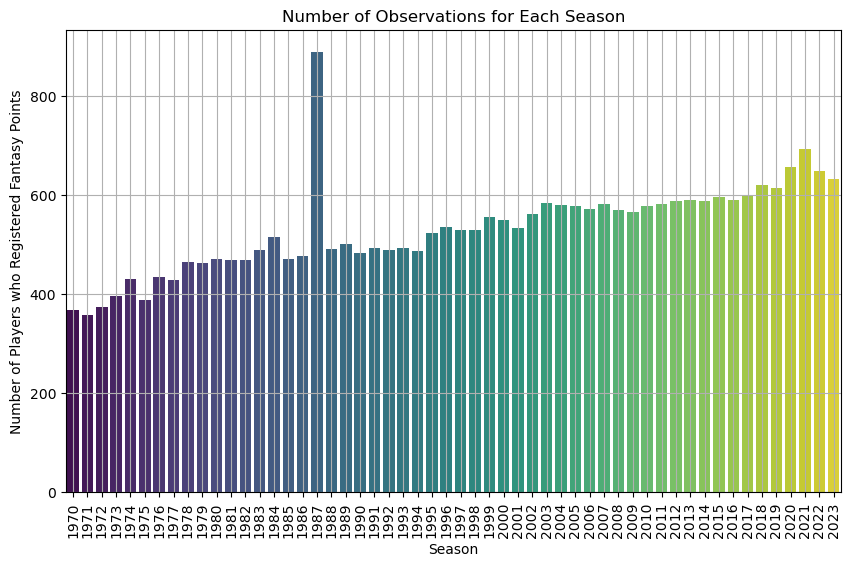

In [18]:
# plot number of observations for each season with 'Year' as the x-axis
plt.figure(figsize=(10, 6))
sns.countplot(x='Year', data=df, palette='viridis')
plt.title('Number of Observations for Each Season')
plt.ylabel('Number of Players who Registered Fantasy Points')
plt.xlabel('Season')
plt.xticks(rotation=90)
plt.grid()
plt.show()

- The number of fantasy-eligible players per season has steadily rose (by over 60%) for the last 50 years. This is in-line with the idea that teams are more prone to rotating snaps at the RB and WR positions. Although teams still only use 1 QB, rotation is much more commonplace in today's NFL.
- There is a spike in the 1987 season due to an NFL players' strike that occurred that year. During the strike, which lasted from September 22 to October 15, the NFL used replacement players to continue the season.

In [19]:
# cast 'PosRank_ppr' to int
df['PosRank_ppr'] = df['PosRank_ppr'].astype(int)

# positional groups we'll be using
qb = df[df.Pos == 'QB']
rb = df[df.Pos == 'RB']
wr = df[df.Pos == 'WR']
te = df[df.Pos == 'TE']

# calculate number of observations for each season
qb_count = qb.groupby('Year').size().reset_index(name='Count')
rb_count = rb.groupby('Year').size().reset_index(name='Count')
wr_count = wr.groupby('Year').size().reset_index(name='Count')
te_count = te.groupby('Year').size().reset_index(name='Count')

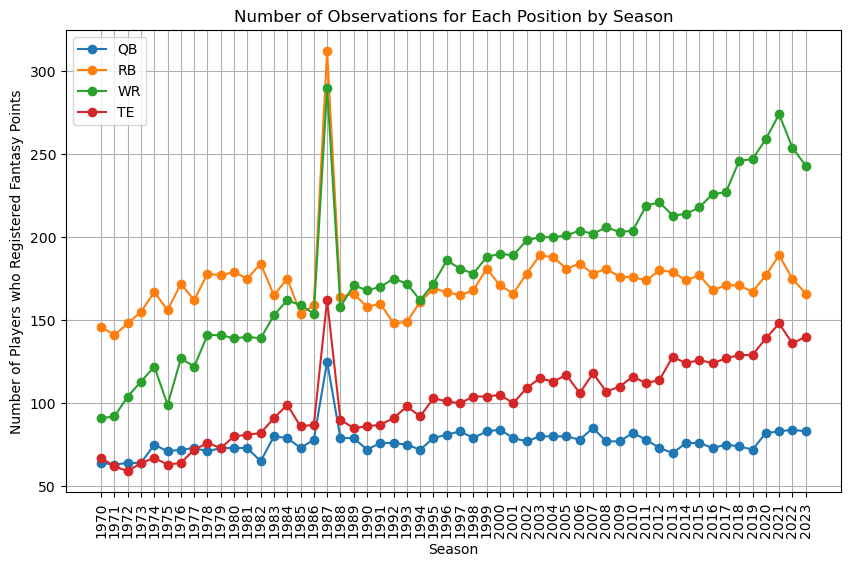

In [6]:
# plot
plt.figure(figsize=(10, 6))
plt.plot(qb_count.Year, qb_count.Count, label='QB', marker='o')
plt.plot(rb_count.Year, rb_count.Count, label='RB', marker='o')
plt.plot(wr_count.Year, wr_count.Count, label='WR', marker='o')
plt.plot(te_count.Year, te_count.Count, label='TE', marker='o')
plt.title('Number of Observations for Each Position by Season')
plt.ylabel('Number of Players who Registered Fantasy Points')
plt.xlabel('Season')
plt.xticks(years, rotation=90)
plt.legend()
plt.grid()
plt.show()

In [7]:
# calculate percentage increase for each group from 1970 to 2023
qb_increase = (qb_count.iloc[-1]['Count'] - qb_count.iloc[0]['Count']) / qb_count.iloc[0]['Count'] * 100
rb_increase = (rb_count.iloc[-1]['Count'] - rb_count.iloc[0]['Count']) / rb_count.iloc[0]['Count'] * 100
wr_increase = (wr_count.iloc[-1]['Count'] - wr_count.iloc[0]['Count']) / wr_count.iloc[0]['Count'] * 100
te_increase = (te_count.iloc[-1]['Count'] - te_count.iloc[0]['Count']) / te_count.iloc[0]['Count'] * 100
print(f'QB: {qb_increase:.2f}%')
print(f'RB: {rb_increase:.2f}%')
print(f'WR: {wr_increase:.2f}%')
print(f'TE: {te_increase:.2f}%')

QB: 29.69%
RB: 13.70%
WR: 167.03%
TE: 108.96%


- The number of QBs has increased slightly increased each season.
- RB has not increased by much.
- WR has boomed. 
- TE has also increased sharply.

### Points

In [20]:
# group we will be using
pos_groups = df.groupby(['Year', 'Pos'])

# constant that will be used for plotting
bins = int(np.sqrt(len(df)))

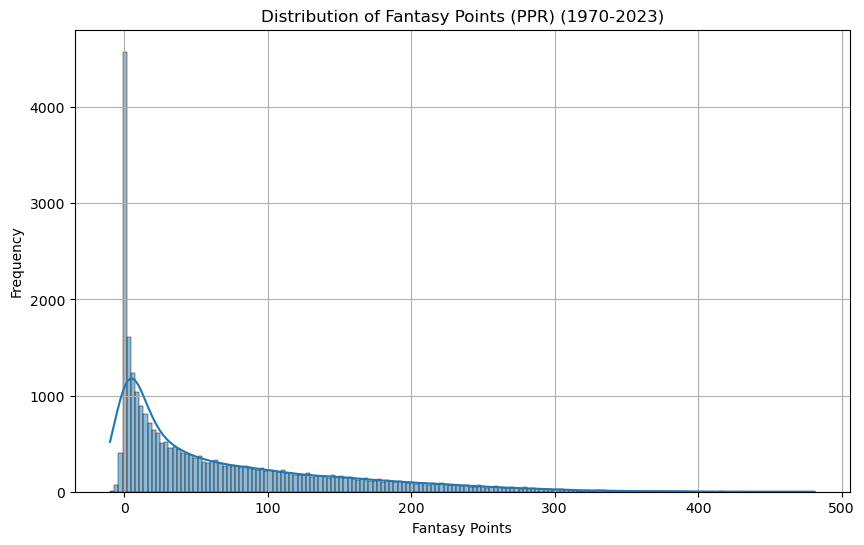

In [9]:
# plot distribution of fantasy points
plt.figure(figsize=(10, 6))
sns.histplot(df['Points_ppr'], bins=bins, kde=True)
plt.title('Distribution of Fantasy Points (PPR) (1970-2023)')
plt.xlabel('Fantasy Points')
plt.ylabel('Frequency')
plt.grid()
plt.show()

In [10]:
# describe the column
df['Points_ppr'].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
Points_ppr,28740.0,66.46334,77.100034,-9.8,5.9,35.6,104.855,481.1


- As we can see above, the mean fantasy points per season is quite low (66) due to the large number of low-volume players (2nd or 3rd strings) included.
- The standard deviation (77) is larger than the mean, which shows how volatile (and top-heavy) points really are.

Now, we will view the statistic by year and for each positional group.

In [21]:
# turn above code into a function
def plot_position_points(df, col, agg):

    '''
    Function to plot the distribution of fantasy points for each position

    Parameters:
    df: DataFrame
    col: str, column name
    agg: str, aggregation function

    Returns:
    None
    
    '''

    # error handling
    assert col in ['Points_ppr', 'VORP_ppr_10tm'], 'Invalid column name'
    assert agg in ['sum', 'mean', 'median', 'std', 'max', 'min'], 'Invalid aggregation function'

    # vars we will be using
    pos_groups = df.groupby(['Year', 'Pos'])
    years = sorted(set(df.Year.to_list()))
    bins = int(np.sqrt(len(df)))

    # initialize a dict to store the data for each position
    pos_data = {'QB': [], 'RB': [], 'WR': [], 'TE': []}

    # iterate over the groups
    for (year, pos), group in pos_groups:
        if agg == 'sum':
            # append value to list
            pos_data[pos].append(group[col].sum())
        elif agg == 'mean':
            pos_data[pos].append(group[col].mean())

    # plot total
    plt.figure(figsize=(10, 6))
    for pos, data in pos_data.items():
        plt.plot(years, data, label=pos)

    plt.title(f'{agg.upper()} of {col} (PPR) per Position (1970-2023)')
    plt.xlabel('Year')
    plt.ylabel('Total Fantasy Points')
    plt.legend()
    plt.grid()
    plt.show()

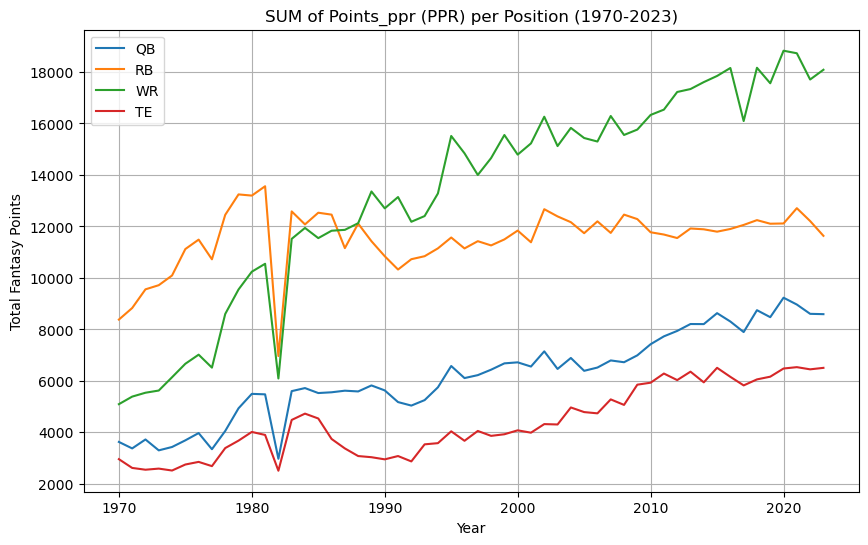

In [62]:
# plot total fantasy points for each position
plot_position_points(df, 'Points_ppr', 'sum')

- The trough in 1982 was due to a player strike, which reduced the 16-game season to a 9-game season.
- Total fantasy points for QBs, RBs, and TEs have steadily rose.
- Until 1984, RBs scored more total points than WRs (by a noticeable margin). Since then, WRs have have steadily increased this gap and RBs have stayed around 18k PPR points per season.
- As we see below, the __mean__ points for a WR hasn't significantly increased. __Total__ points for WRs have skyrocketed due to the much larger pool of recievers in the league today. This may mean that __value can be found at WR in later rounds__.

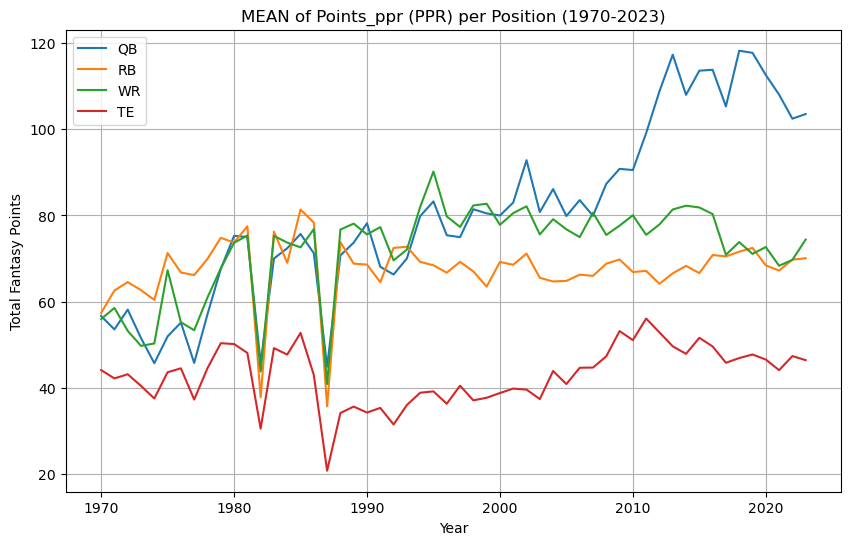

In [63]:
# plot mean fantasy points for each position
plot_position_points(df, 'Points_ppr', 'mean')

- Average QB points have rose by over 50%, especially after 2006. This may be due to the pass-heavy nature of NFL offenses today.
- Average RB and WR points have both risen by about 20%.
- Average TE points are sbout the same.

### Value Over Replacement Player
Now, we will analyze how VORP has changed over the years. Keep in mind, these VORP values were calculated for a 10-team league with the following roster setup:
- 1 QB
- 2 RB
- 2 WR
- 1 TE
- 1 FLEX

Thus, the replacement players are:
- QB10
- RB25 (assuming half the flex spots are RBs)
- WR25 (assuming half the flex spots are WRs)
- TE10

For a 12-team league or a league with 3 WRs or 2 FLEX spots, this analysis won't be 100% accurate.

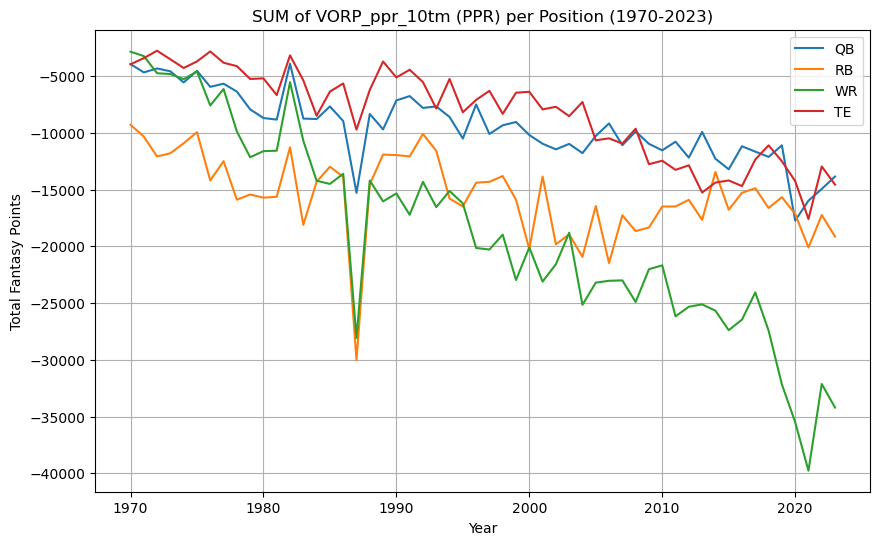

In [64]:
# plot total VORP for each position
plot_position_points(df, 'VORP_ppr_10tm', 'sum')

- Total VORP has steadily decreased for every position. This is likely due to the increased depth of low volume players. This was less likely prior to 1990, as there were much less rotation of snaps between players.
- WR saw a subsstantial decrease after 2010. This is likely due to the prevelance of heavy WR rotation in today's offenses (as you increase the pool of WRs in the league, there will be more players who finish worse than WR25).

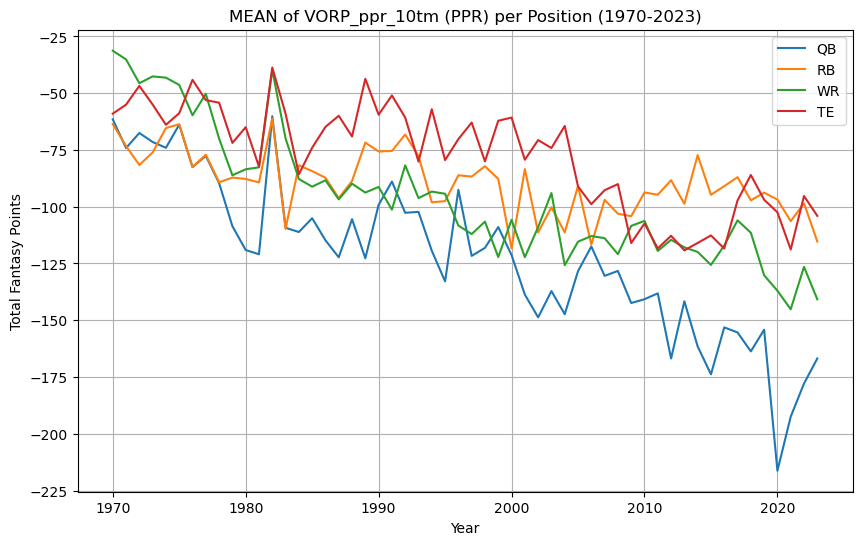

In [65]:
# plot mean VORP for each position
plot_position_points(df, 'VORP_ppr_10tm', 'mean')

- Average VORP significantly decreased for the QB position. Since the total VORP for QBs didn't decrease that significantly, this likely means that over time, there were increasingly more QBs who registered snaps in a season (who had negative VORP). This would drag down the mean.

## Does a Positive VORP Season increase the likelihood of another?

In [ ]:
# add column 'num_pos_VORP' seasons where player had VORP >= 0 in there previous years
starters['num_pos_VORP'] = starters.groupby('Key')['VORP_ppr_10tm'].transform(lambda x: x.gt(0).cumsum()) - 1

# set negative values to 0
starters.loc[starters.num_pos_VORP < 0, 'num_pos_VORP'] = 0

# check
starters[starters.Player == 'Tom Brady'][['Player', 'Year', 'GS', 'VORP_ppr_10tm', 'num_pos_VORP']]

C:\Users\heefj\AppData\Local\Temp\ipykernel_26940\3415477341.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  starters['num_pos_VORP'] = starters.groupby('Key')['VORP_ppr_10tm'].transform(lambda x: x.gt(0).cumsum()) - 1


,Player,Year,GS,VORP_ppr_10tm,num_pos_VORP
14727,Tom Brady,2000,0,-201.04,0
15307,Tom Brady,2001,14,-58.38,0
15946,Tom Brady,2002,16,0.00,0
16434,Tom Brady,2003,16,-2.84,0
17118,Tom Brady,2004,16,-6.98,0
17654,Tom Brady,2005,16,41.04,0
18236,Tom Brady,2006,16,14.28,1
18822,Tom Brady,2007,16,179.66,2
19160,Tom Brady,2008,1,-212.58,2
20002,Tom Brady,2009,16,35.10,3


In [ ]:
# get number of seasons where VORP was positive for each Key
starters_vorp = starters[starters['VORP_ppr_10tm'] >= 0].groupby('Key').size().reset_index(name='Count')
starters_vorp.sort_values('Count', ascending=False)

In [ ]:
# see if there are any duplicate 'Player' values who have different 'Key' values
starters.groupby('Player')['Key'].nunique().sort_values(ascending=False).head(7)

## Takeaways:
1. 
2. 
3.
4.
5.
